Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8306 - loss: 0.4430 - val_accuracy: 0.9068 - val_loss: 0.2251 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9377 - loss: 0.1852 - val_accuracy: 0.9357 - val_loss: 0.1654 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9561 - loss: 0.1304 - val_accuracy: 0.9405 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9544 - loss: 0.1259 - val_accuracy: 0.9486 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9702 - loss: 0.0915 - val_accuracy: 0.9518 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9756 - loss: 0.0788 - val_accuracy: 0.9550 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9709 - loss: 0.0821 - val_acc

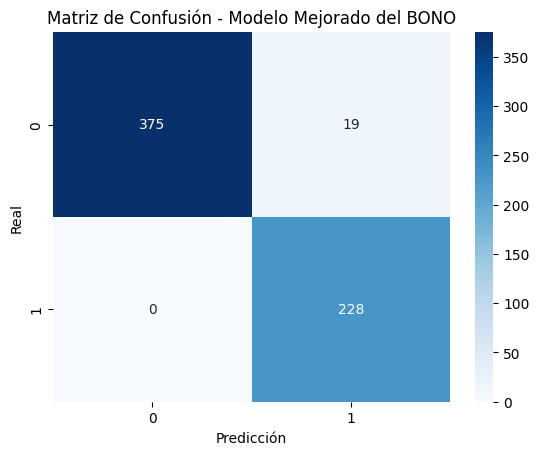

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 Mejor vino según el modelo (mayor probabilidad de ser clase 5):

winery: Matarromera
year: 2011.0
rating: 4.2
num_reviews: 389
price: 64.5
body: 5.0
acidity: 3.0
country: Espana
region: Ribera del Duero
type: Ribera Del Duero Red

 Probabilidad predicha de ser clase 5: 0.9998


In [7]:
# Modelo optimizado para el BONO – F1-score máximo con aumento de clase 5

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 2. Cargar CSV local
df = pd.read_csv("wines_SPA.csv")

# 3. Filtrar clases 4 y 5
df = df[df['rating'].round().isin([4, 5])]

# 4. Limpieza y tratamiento de nulos
df = df.drop(columns=['wine'])
num_cols = ['year', 'price', 'num_reviews', 'body', 'acidity']
df[num_cols] = df[num_cols].replace("N.V.", pd.NA)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_cols + ['rating'])

# Guardar copia antes de transformación para mostrar datos legibles
df_original = df.copy()

# 5. Rebalanceo mejorado
df['rating_class'] = df['rating'].round().astype(int)
df_5 = df[df['rating_class'] == 5]
df_5 = pd.concat([df_5] * 7, ignore_index=True)  # aumentamos clase 5 aún más

df_4 = df[df['rating_class'] == 4].sample(n=int(len(df_5) * 0.9), random_state=42)  # solo reducimos un poco clase 4

df = pd.concat([df_4, df_5], ignore_index=True)

df = pd.concat([df_4, df_5], ignore_index=True)

# 6. Tratamiento de outliers
def eliminar_outliers_iqr(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df = eliminar_outliers_iqr(df, ['price', 'num_reviews', 'body', 'acidity'])

# 7. Codificación y normalización
df = pd.get_dummies(df, columns=['winery', 'country', 'region', 'type'], drop_first=True)
df[num_cols] = df[num_cols].astype('float64')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 8. División del dataset
X = df.drop(columns=['rating', 'rating_class'])
y = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train - 4, num_classes=2)
y_test_cat = to_categorical(y_test - 4, num_classes=2)

# 9. Modelo optimizado – arquitectura profunda
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 10. Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 11. Entrenamiento
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 12. Evaluación con ajuste de umbral
y_pred = model.predict(X_test)
y_pred_labels = (y_pred[:,1] > 0.45).astype(int) + 4
y_true_labels = np.argmax(y_test_cat, axis=1) + 4

print("== Resultados del Modelo Mejorado para el BONO ==")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[4, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo Mejorado del BONO")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MEJOR VINO SEGÚN EL MODELO ===

# Predicciones para todo el dataset (usando modelo final)
y_all_pred = model.predict(X)
probs_clase_5 = y_all_pred[:, 1]

# Índice del vino con mayor probabilidad de ser clase 5
indice_mejor_vino = np.argmax(probs_clase_5)
mejor_vino = df_original.iloc[indice_mejor_vino]

# Mostrar columnas clave de forma limpia
print("\n Mejor vino según el modelo (mayor probabilidad de ser clase 5):\n")
for col, val in mejor_vino[['winery', 'year', 'rating', 'num_reviews', 'price', 'body', 'acidity', 'country', 'region', 'type']].items():
    print(f"{col}: {val}")

print(f"\n Probabilidad predicha de ser clase 5: {probs_clase_5[indice_mejor_vino]:.4f}")

<ipython-input-9-6c0e63244453>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_class'] = df['rating'].round().astype(int)


Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7992 - loss: 0.4786 - val_accuracy: 0.9100 - val_loss: 0.2112 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9343 - loss: 0.1827 - val_accuracy: 0.9325 - val_loss: 0.1629 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9454 - loss: 0.1480 - val_accuracy: 0.9373 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9579 - loss: 0.1152 - val_accuracy: 0.9614 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9612 - loss: 0.0999 - val_accuracy: 0.9598 - val_loss: 0.1188 - learning_rate: 0.0010
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9661 - loss: 0.0943 - val_accuracy: 0.9598 - val_loss: 0.1327 - learning_rate: 0.0010
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9664 - loss: 0.0955 - val_acc

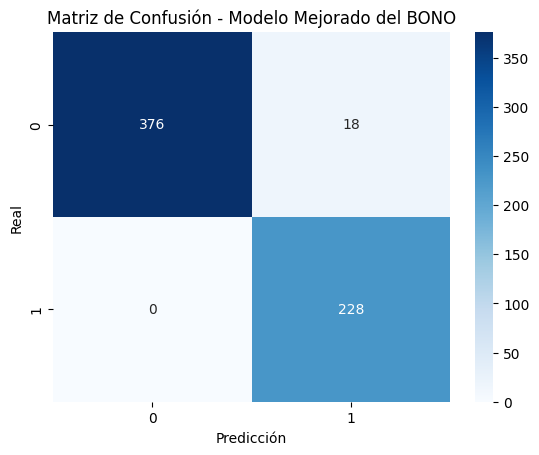

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Mejor vino según el modelo (mayor probabilidad de ser clase 5):

winery: Mar de Frades
year: 2015.0
rating: 4.2
num_reviews: 414
price: 16.78
body: 3.0
acidity: 3.0
country: Espana
region: Rias Baixas
type: Albarino

 Probabilidad predicha de ser clase 5: 0.9997


In [9]:
# Modelo optimizado para el BONO – F1-score máximo con aumento de clase 5
# Y cambio de salidaa 1 neurona + activacion sigmoid, usando binary_crossentropy como funcion de perdida

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 2. Cargar CSV local
df = pd.read_csv("wines_SPA.csv")

# 3. Filtrar clases 4 y 5
df = df[df['rating'].round().isin([4, 5])]

# 4. Limpieza y tratamiento de nulos
df = df.drop(columns=['wine'])
num_cols = ['year', 'price', 'num_reviews', 'body', 'acidity']
df[num_cols] = df[num_cols].replace("N.V.", pd.NA)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_cols + ['rating'])

# Guardar copia antes de transformación para mostrar datos legibles
df_original = df.copy()

# 5. Rebalanceo mejorado
df['rating_class'] = df['rating'].round().astype(int)
df_5 = df[df['rating_class'] == 5]
df_5 = pd.concat([df_5] * 7, ignore_index=True)  # aumentamos clase 5 aún más

df_4 = df[df['rating_class'] == 4].sample(n=int(len(df_5) * 0.9), random_state=42)  # solo reducimos un poco clase 4

df = pd.concat([df_4, df_5], ignore_index=True)

df = pd.concat([df_4, df_5], ignore_index=True)

# 6. Tratamiento de outliers
def eliminar_outliers_iqr(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df = eliminar_outliers_iqr(df, ['price', 'num_reviews', 'body', 'acidity'])

# 7. Codificación y normalización
df = pd.get_dummies(df, columns=['winery', 'country', 'region', 'type'], drop_first=True)
df[num_cols] = df[num_cols].astype('float64')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 8. División del dataset
X = df.drop(columns=['rating', 'rating_class'])
y = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Cambio aqui a version binaria
y_train_bin = y_train - 4  # etiquetas: 0 y 1
y_test_bin = y_test - 4

# 9. Modelo optimizado – arquitectura profunda
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # salida binaria
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 10. Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 11. Entrenamiento
history = model.fit(
    X_train, y_train_bin,
    validation_data=(X_test, y_test_bin),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 12. Evaluación con ajuste de umbral
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.45).astype(int) + 4  # convierte 0/1 a 4/5
y_true_labels = y_test.values

print("== Resultados del Modelo Mejorado para el BONO ==")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[4, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo Mejorado del BONO")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MEJOR VINO SEGÚN EL MODELO ===

# Predicciones para todo el dataset (usando modelo final)
y_all_pred = model.predict(X)
probs_clase_5 = y_all_pred.flatten()

# Índice del vino con mayor probabilidad de ser clase 5
indice_mejor_vino = np.argmax(probs_clase_5)
mejor_vino = df_original.iloc[indice_mejor_vino]

# Mostrar columnas clave de forma limpia
print("\n Mejor vino según el modelo (mayor probabilidad de ser clase 5):\n")
for col, val in mejor_vino[['winery', 'year', 'rating', 'num_reviews', 'price', 'body', 'acidity', 'country', 'region', 'type']].items():
    print(f"{col}: {val}")

print(f"\n Probabilidad predicha de ser clase 5: {probs_clase_5[indice_mejor_vino]:.4f}")

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8234 - loss: 0.4617 - val_accuracy: 0.9148 - val_loss: 0.2140 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9284 - loss: 0.1894 - val_accuracy: 0.9325 - val_loss: 0.1690 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9461 - loss: 0.1451 - val_accuracy: 0.9502 - val_loss: 0.1398 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9673 - loss: 0.0954 - val_accuracy: 0.9357 - val_loss: 0.1562 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9704 - loss: 0.0997 - val_accuracy: 0.9453 - val_loss: 0.1445 - learning_rate: 0.0010
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9703 - loss: 0.0888 - val_accuracy: 0.9598 - val_loss: 0.1288 - learning_rate: 0.0010
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9725 - loss: 0.0834 - val_acc

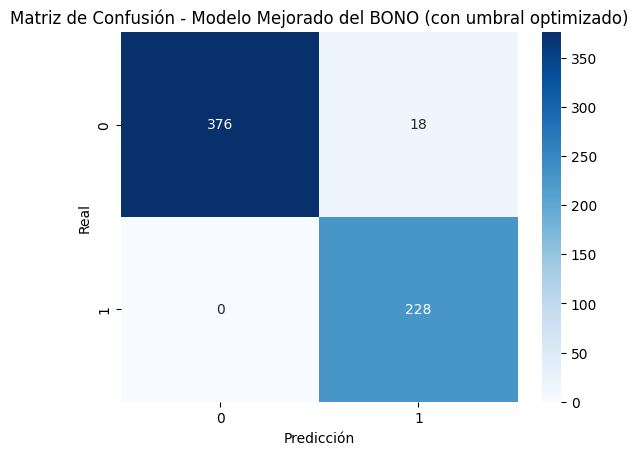

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🍷 Mejor vino según el modelo (mayor probabilidad de ser clase 5):

winery: Matarromera
year: 2011.0
rating: 4.2
num_reviews: 389
price: 64.5
body: 5.0
acidity: 3.0
country: Espana
region: Ribera del Duero
type: Ribera Del Duero Red

✅ Probabilidad predicha de ser clase 5: 0.9997


In [14]:
# Modelo optimizado para el BONO – F1-score máximo con aumento de clase 5
# y salida con 1 neurona + activación sigmoid + binary_crossentropy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 1. Cargar CSV local
df = pd.read_csv("wines_SPA.csv")

# 2. Filtrar clases 4 y 5
df = df[df['rating'].round().isin([4, 5])]

# 3. Limpieza y nulos
df = df.drop(columns=['wine'])
num_cols = ['year', 'price', 'num_reviews', 'body', 'acidity']
df[num_cols] = df[num_cols].replace("N.V.", pd.NA)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_cols + ['rating'])

# Guardar copia antes de transformación para mostrar datos legibles
df_original = df.copy()

# 4. Rebalanceo mejorado
df['rating_class'] = df['rating'].round().astype(int)
df_5 = df[df['rating_class'] == 5]
df_5 = pd.concat([df_5] * 7, ignore_index=True)
df_4 = df[df['rating_class'] == 4].sample(n=int(len(df_5) * 0.9), random_state=42)
df = pd.concat([df_4, df_5], ignore_index=True)

# 5. Outliers
def eliminar_outliers_iqr(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df = eliminar_outliers_iqr(df, ['price', 'num_reviews', 'body', 'acidity'])

# 6. Codificación y normalización
df = pd.get_dummies(df, columns=['winery', 'country', 'region', 'type'], drop_first=True)
df[num_cols] = df[num_cols].astype('float64')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 7. Dataset y etiquetas binarizadas
X = df.drop(columns=['rating', 'rating_class'])
y = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_bin = y_train - 4
y_test_bin = y_test - 4

# 8. Modelo con sigmoid y binary_crossentropy
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 9. Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 10. Entrenamiento
history = model.fit(
    X_train, y_train_bin,
    validation_data=(X_test, y_test_bin),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 11. Predicción y búsqueda del mejor umbral
y_pred = model.predict(X_test)
y_true_labels = y_test_bin + 4  # [4, 5]

# Buscar el umbral óptimo para F1 clase 5
mejores_resultados = {"f1": 0, "umbral": 0.5}
for t in np.arange(0.30, 0.71, 0.01):
    y_temp = (y_pred > t).astype(int) + 4
    f1 = f1_score(y_true_labels, y_temp, pos_label=5)
    if f1 > mejores_resultados["f1"]:
        mejores_resultados["f1"] = f1
        mejores_resultados["umbral"] = t

# Aplicar el mejor umbral encontrado
print(f"🔍 Mejor umbral encontrado: {mejores_resultados['umbral']:.2f} con F1-clase 5: {mejores_resultados['f1']:.4f}")
umbral_optimo = mejores_resultados["umbral"]
y_pred_labels = (y_pred > umbral_optimo).astype(int) + 4

# 12. Evaluación final
print("== Resultados del Modelo Mejorado para el BONO ==")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[4, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo Mejorado del BONO (con umbral optimizado)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MEJOR VINO SEGÚN EL MODELO ===
y_all_pred = model.predict(X)
probs_clase_5 = y_all_pred.flatten()
indice_mejor_vino = np.argmax(probs_clase_5)
mejor_vino = df_original.iloc[indice_mejor_vino]

print("\n Mejor vino según el modelo (mayor probabilidad de ser clase 5):\n")
for col, val in mejor_vino[['winery', 'year', 'rating', 'num_reviews', 'price', 'body', 'acidity', 'country', 'region', 'type']].items():
    print(f"{col}: {val}")
print(f"\n Probabilidad predicha de ser clase 5: {probs_clase_5[indice_mejor_vino]:.4f}")